# Before Start
### install packages numpy pandas scipy scikit-learn statsmodels geomstats matplotlib seaborn by
> !pip install numpy pandas scipy scikit-learn statsmodels geomstats matplotlib seaborn 

In [1]:
!pip install numpy pandas scipy scikit-learn statsmodels geomstats matplotlib seaborn 

   ---------------------------------------- 0.0/15.9 MB ? eta -:--:--
   ------------- -------------------------- 5.5/15.9 MB 37.2 MB/s eta 0:00:01
   -------------------------------------- - 15.5/15.9 MB 37.4 MB/s eta 0:00:01
   ---------------------------------------- 15.9/15.9 MB 33.4 MB/s  0:00:00
   ---------------------------------------- 0.0/11.4 MB ? eta -:--:--
   ---------------------------------------  11.3/11.4 MB 58.9 MB/s eta 0:00:01
   ---------------------------------------- 11.4/11.4 MB 50.7 MB/s  0:00:00
   ---------------------------------------- 0.0/46.2 MB ? eta -:--:--
   ---------- ----------------------------- 12.6/46.2 MB 60.7 MB/s eta 0:00:01
   ---------------------- ----------------- 25.4/46.2 MB 62.0 MB/s eta 0:00:01
   --------------------------------- ------ 38.5/46.2 MB 61.2 MB/s eta 0:00:01
   ---------------------------------------  46.1/46.2 MB 61.2 MB/s eta 0:00:01
   ---------------------------------------- 46.2/46.2 MB 54.5 MB/s  0:00:00
   -------

In [1]:
import os, sys
sys.path.append(os.path.join(*str(os.getcwd()).split('\\')[:-1]).replace(':',':\\'))
import riemannian_robust_m_estimator as rrm
import numpy as np
import pandas as pd
# 최대 열(column) 수 제한 해제
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns

import os, time, pickle

import geomstats.backend as gs
import geomstats.visualization as visualization
from geomstats.geometry.euclidean import Euclidean
from geomstats.geometry.hyperboloid import Hyperboloid
from geomstats.geometry.hypersphere import Hypersphere
from geomstats.geometry.poincare_ball import PoincareBall
from geomstats.geometry.poincare_half_space import PoincareHalfSpace
from geomstats.geometry.spd_matrices import SPDMatrices
from geomstats.geometry.special_euclidean import SpecialEuclidean
from geomstats.geometry.special_orthogonal import SpecialOrthogonal
from geomstats.learning.frechet_mean import FrechetMean
from geomstats.learning.geometric_median import GeometricMedian

def get_sq_bias_from_mean(sample_means, manifold, mu, samplingdist):
    if samplingdist == 'gaussian':
        def squaredist(space,points,base,critical_value,weights=None,loss_and_grad=True):
            n = len(points)
            logs = space.metric.log(points,base)
            dists = space.metric.dist(points,base)
        
            loss = gs.sum(dists**2)/n
            if not loss_and_grad:
                return loss
            grad = -2*gs.sum(logs,axis=0)/n
            return loss, space.to_tangent(grad,base)
            
        fm = rrm.RiemannianRobustMestimator(
                    space=manifold,
                    method='default',
                    m_estimator='custom',
                    critical_value=None,
                    init_point_method='mean-projection',
                )
        fm.set_loss(squaredist)
        fm.set(init_step_size=2, max_iter=2048, epsilon=1e-6)
        fm.fit(sample_means)
        mean_of_means = fm.estimate_.x
    else:
        gm = GeometricMedian(manifold,max_iter=2048,epsilon=1e-6)
        gm.fit(sample_means)
        mean_of_means = gm.estimate_
    bias = mean_of_means - mu #['hardr_60.00']
        
    return bias.T @ bias, mean_of_means



In [ ]:
os.getcwd()

In [46]:
import logging
logging.basicConfig(level=logging.ERROR)
logging.getLogger('root').setLevel(logging.ERROR)
import warnings
warnings.filterwarnings("ignore")

# Reload sample mean variance simulation data

In [ ]:
folder = 'sphere'
res = {1000:{}}
for n_samples in [1000]: #,300]: #= 25
    res[n_samples] = {}
    for i in range(10):
        ix = f'_{i}'  #'' if i==0 else 
        with open(f'{folder}/varofsamplemean_simul_n{n_samples}_cov3type_mest{ix}.pkl','rb') as f_:
            res[n_samples][i] = pickle.load(f_)
        
folder = 'hyperbolic'
resh = {1000:{}}
for n_samples in [1000]: #,300]: #= 25
    resh[n_samples] = {}
    for i in range(10):
        ix = f'_{i}'  #'' if i==0 else 
        with open(f'{folder}/varofsamplemean_simul_n{n_samples}_cov3type_mest{ix}.pkl','rb') as f_:
            resh[n_samples][i] = pickle.load(f_)

folder = 'euclidean'
rese = {1000:{}}
for n_samples in [1000]: #,300]: #= 25
    rese[n_samples] = {}
    for i in range(10):
        ix = f'_{i}'  #'' if i==0 else 
        with open(f'{folder}/varofsamplemean_simul_n{n_samples}_cov3type_mest{ix}.pkl','rb') as f_:
            rese[n_samples][i] = pickle.load(f_)

with open('covs.pkl','rb') as f_:
    covs = pickle.load(f_)

# Convert dictionary rawdata to dataframe for plotting

In [ ]:
mean_list = list(res[1000][0][2]['gaussian']['full-rank']['mean'].keys())
manifolds = {
    'sphere': lambda d: Hypersphere(dim=d),
    'euclidean': lambda d: Euclidean(dim=d),
    'hyperbolic': lambda d: Hyperboloid(dim=d)
}

mflds = ['sphere','euclidean','hyperbolic']
dims = [2,5,10,20,50,100,500]
sdists = ['gaussian','t','laplace']
covtypes = ['full-rank','half-rank','low-rank']

cutoff_df = pd.DataFrame()
sample_mean_vars = {}
REs = {}
ns = []
tic = time.time()
for d in dims:
    sample_mean_vars[d] = {}
    REs[d] = {}
    mu_base = [0.0] * d
    for mfld in mflds:
        manifold = manifolds[mfld](d)
        
        if mfld == 'sphere': mu_ = np.append(mu_base, 1.0)
        elif mfld == 'euclidean': mu_ = np.array(mu_base)
        else: mu_ = np.insert(mu_base, 0, 1.0)

        sample_mean_vars[d][mfld] = {}
        REs[d][mfld] = {}
        for sdt in sdists:
            sample_mean_vars[d][mfld][sdt] = {}
            REs[d][mfld][sdt] = {}
            for ctp in covtypes:
                sample_mean_vars[d][mfld][sdt][ctp] = {}
                REs[d][mfld][sdt][ctp] = {}

                temp_cutoff_list = []
                for i in range(10):
                    try:
                        if mfld == 'sphere':
                            tg = res[1000][i][d][sdt][ctp]
                        elif mfld == 'euclidean':
                            tg = rese[1000][i][d][sdt][ctp]
                        else:
                            tg = resh[1000][i][d][sdt][ctp]
                    except KeyError:
                        pass

                    tg_cutoff = pd.DataFrame(tg['cutoff'])
                    temp_cutoff_list.append(tg_cutoff)
                
                if not temp_cutoff_list: continue
                combined_cutoff = pd.concat(temp_cutoff_list, axis=0)
                cutoff1 = combined_cutoff.mean(axis=0).reset_index()
                cutoff1.columns = ['ptile', 'cutoff_ratio']
                cutoff1['cutoff_ratio'] /= np.sqrt(0.1)
                
                cutoff1['d'] = d
                cutoff1['manifold'] = mfld
                cutoff1['samplingdist'] = sdt
                cutoff1['cov_type'] = ctp
                cutoff_df = pd.concat((cutoff_df,cutoff1),axis=0)
                
                for m in ['fm']+[_ for _ in mean_list if _ != 'fm']:
                    temp_mean_collect = []
                    for i in range(10):
                        try:
                            if mfld == 'sphere':
                                tg = res[1000][i][d][sdt][ctp]
                                check_ix = 0
                            elif mfld == 'euclidean':
                                tg = rese[1000][i][d][sdt][ctp]
                                check_ix = 0
                            else:
                                tg = resh[1000][i][d][sdt][ctp]
                                check_ix = 1
                            tg_mean = np.array(tg['mean'][m])
                            valid_mask = (np.abs(tg_mean[:,0] - 9999) > 1e-5) & (np.abs(tg_mean[:,check_ix]) < 0.05)
                            tg_mean = np.array(tg_mean[valid_mask])
                            temp_mean_collect.append(tg_mean)
                        except KeyError:
                            pass
                    if not temp_mean_collect: continue
                    mean_data1 = np.concatenate(temp_mean_collect, axis=0)
                    if mean_data1.shape[0]==0:
                        continue
                    if mean_data1.shape[0]<=800:
                        if d<500:
                            print(d,mfld,sdt,ctp,m)
                    ns.append([d,mfld,sdt,ctp,m,mean_data1.shape[0]])
                    rmv = rrm.riemannian_variance(
                        space=manifold, points=mean_data1, base=mu_)
                    if m == 'fm':
                        base_var = rmv
                    RE1 = base_var/rmv
                    sample_mean_vars[d][mfld][sdt][ctp][m] = rmv
                    REs[d][mfld][sdt][ctp][m] = RE1
                # print(d,mfld,sdt,ctp,'finished',time.time()-tic)
ns = pd.DataFrame(ns,columns=['d','manifold','samplingdist','cov_type','mean_type','n'])
rows = []
for d, mflds in REs.items():
    for mfld, sdts in mflds.items():
        for sdt, ctps in sdts.items():
            for ctp, ms in ctps.items():
                for m, value in ms.items():
                    rows.append({
                        'd': d,
                        'manifold': mfld,
                        'samplingdist': sdt,
                        'cov_type': ctp,
                        'mean_type': m,
                        'value': value
                    })

res_df_g_ = pd.DataFrame(rows)
res_df_g_['summary_type'] = 'ARE'
rows = []
for d, mflds in sample_mean_vars.items():
    for mfld, sdts in mflds.items():
        for sdt, ctps in sdts.items():
            for ctp, ms in ctps.items():
                for m, value in ms.items():
                    rows.append({
                        'd': d,
                        'manifold': mfld,
                        'samplingdist': sdt,
                        'cov_type': ctp,
                        'mean_type': m,
                        'value': value
                    })
df_v = pd.DataFrame(rows)
df_v['summary_type'] = 'sample_mean_var'
res_df_g_ = pd.concat((res_df_g_,df_v),axis=0).reset_index(drop=True)
print(res_df_g_.shape[0])
res_df_g_ = res_df_g_.merge(ns,on=['d','manifold','samplingdist','cov_type','mean_type'],how='left')
print(res_df_g_.shape[0])
res_df_g_['ptile'] = [i.split('_')[-1] if '_' in i else '0.00' for i in res_df_g_['mean_type']]
res_df_g_['mean_type'] = [i.split('_')[0] for i in res_df_g_['mean_type']]
res_df_g_['M-estimator'] = np.where(res_df_g_['mean_type']=='mono','Huber',
                             np.where(res_df_g_['mean_type']=='softr','Cauchy',
                                      np.where(res_df_g_['mean_type']=='hardr','Hampel',
                                        res_df_g_['mean_type'])))
res_df_g_['M-estimator'] = np.where(res_df_g_['M-estimator']=='fm','Fréchet',
                                    np.where(res_df_g_['M-estimator']=='gm','Geo.median',
                                        res_df_g_['M-estimator']))
cutoff_df['ptile'] = [f'{i:0>2.2f}' for i in cutoff_df['ptile']]
print(res_df_g_.shape)
res_df_g_ = res_df_g_.merge(cutoff_df,on=['d','manifold','samplingdist','cov_type','ptile'],how='left')
print(res_df_g_.shape)
effranks = []
for d in dims:
    for ctp in covtypes:
        eig1 = np.diag(covs[d][ctp][0])
        effranks.append([d,ctp,np.sum(eig1)/np.max(eig1)])
effranks = pd.DataFrame(effranks,columns=['d','cov_type','eff_rank'])
print(res_df_g_.shape)
res_df_g_ = res_df_g_.merge(effranks,on=['d','cov_type'],how='left')
print(res_df_g_.shape)
res_df_g_.to_csv('result_RE_varofmeans.csv',index=False)


2 sphere gaussian half-rank hardr_5.00
2 sphere gaussian half-rank hardr_10.00
2 sphere gaussian half-rank hardr_15.00
2 sphere gaussian low-rank softr_5.00
2 sphere gaussian low-rank hardr_5.00
2 sphere gaussian low-rank hardr_10.00
2 sphere gaussian low-rank hardr_15.00
2 sphere t half-rank hardr_5.00
2 sphere t low-rank softr_5.00
2 sphere t low-rank hardr_5.00
2 sphere t low-rank hardr_10.00
2 euclidean gaussian half-rank hardr_5.00
2 euclidean gaussian half-rank hardr_10.00
2 euclidean gaussian half-rank hardr_15.00
2 euclidean gaussian low-rank softr_5.00
2 euclidean gaussian low-rank hardr_5.00
2 euclidean gaussian low-rank hardr_10.00
2 euclidean gaussian low-rank hardr_15.00
2 euclidean t half-rank hardr_5.00
2 euclidean t low-rank softr_5.00
2 euclidean t low-rank hardr_5.00
2 hyperbolic gaussian half-rank hardr_5.00
2 hyperbolic gaussian half-rank hardr_10.00
2 hyperbolic gaussian low-rank softr_5.00
2 hyperbolic gaussian low-rank hardr_5.00
2 hyperbolic gaussian low-rank ha

### Read dataframe already made from simulation of RE

In [ ]:
res_df_g_ = pd.read_csv('result_RE_varofmeans.csv')
res_df_g_['ptile'] = [f'{i:0>2.2f}' for i in res_df_g_['ptile']]

# (Not in paper) RE of all simulated cases in one chart(barplot) 

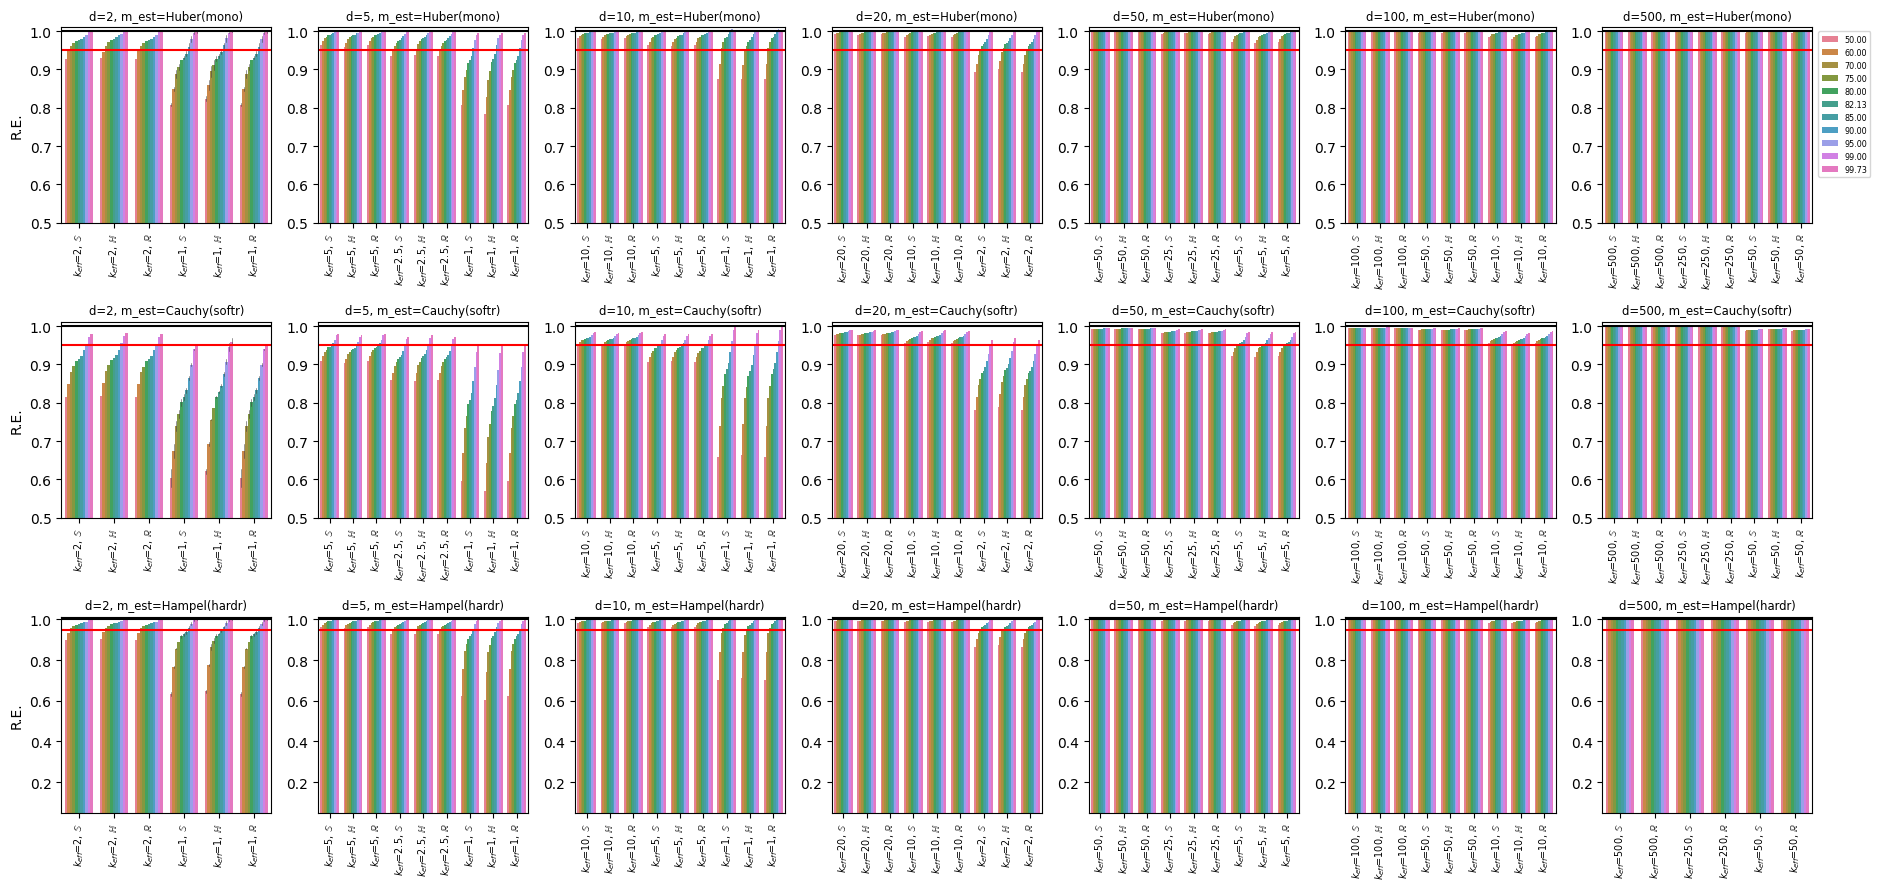

In [330]:
fig,ax = plt.subplots(3,len(dims),figsize=(2.7*len(dims),3*3))
for i,d in enumerate(dims):
    for j,(m_est_type,m_name) in enumerate([('mono','Huber'),('softr','Cauchy'),('hardr','Hampel')]):
        tdf = res_df_g_.loc[
            (res_df_g_['summary_type']=='ARE') &
            (res_df_g_['mean_type']!='fm') &
            (res_df_g_['d']==d) &
            (pd.to_numeric(res_df_g_['ptile'])>49) &
            (res_df_g_['mean_type']==m_est_type) &
            (res_df_g_['samplingdist']=='gaussian')  #gaussian
        ].copy(deep=True).sort_values(['eff_rank','manifold'],ascending=False).reset_index(drop=True)
        
        tdf['R.E.'] = tdf['value']
        tdf['eff_rank'] = np.round(tdf['eff_rank'],1).astype(str)
        tdf['eff_rank'] = tdf['eff_rank'].str.replace('.0','',regex=False)
        tdf['m1'] = np.where(tdf['manifold']=='euclidean','$\mathbb{R}$',np.where(tdf['manifold']=='sphere','$\mathbb{S}$','$\mathbb{H}$'))
        tdf['xv'] = '$k_{{eff}}$='+tdf['eff_rank']+', '+tdf['m1']
        sns.barplot(data=tdf,x='xv',y='R.E.',hue='ptile',ax=ax[j,i],errorbar=('sd',2),errwidth=0.39,)
        ax[j,i].axhline(y=0.95,c='r')
        ax[j,i].axhline(y=1,c='k')
        if m_est_type=='hardr':
            ax[j,i].set_ylim(0.05,1.01)
        else:
            ax[j,i].set_ylim(0.5,1.01)
        if (j,i)==(0,len(dims)-1):
            ax[j,i].legend(loc='upper left',fontsize='xx-small',bbox_to_anchor=(1.01,1))
        else:
            ax[j,i].legend_.remove()
        ax[j,i].set_title(f'd={d}, m_est={m_name}({m_est_type})',fontsize='small')
        ax[j,i].tick_params(axis='x',rotation=90,labelsize='x-small')
        ax[j,i].set_xlabel('')
        if i!=0:
            ax[j,i].set_ylabel('')
# fig.suptitle('Relative Efficiency w.r.t. cutoff percentiles, effective ranks, manifolds')
plt.tight_layout()

os.makedirs('plots_for_submit',exist_ok=True)
plt.savefig('plots_for_submit/ARE_by_d_mests_effrank_cutoffptile_allinone.eps', bbox_inches="tight")
plt.savefig('plots_for_submit/ARE_by_d_mests_effrank_cutoffptile_allinone.pdf', bbox_inches="tight")

# (In paper) RE of several simulated cases(d=2,5,20,50, different eff_rank) in one chart(barplot) 

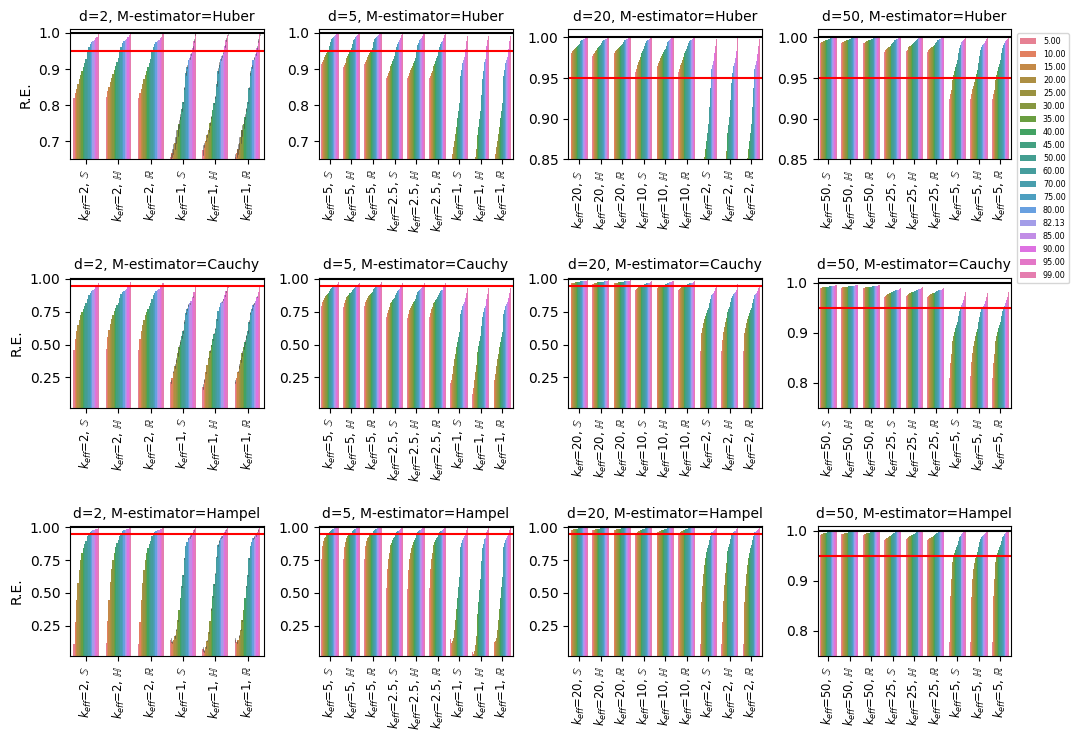

In [331]:
fig,ax = plt.subplots(3,4,figsize=(2.7*4,2.5*3))
for i,d in enumerate([2,5,20,50]):
    for j,(m_est_type,m_name) in enumerate([('mono','Huber'),('softr','Cauchy'),('hardr','Hampel')]):
        tdf = res_df_g_.loc[
            (res_df_g_['summary_type']=='ARE') &
            (res_df_g_['mean_type']!='fm') &
            (res_df_g_['d']==d) &
            (pd.to_numeric(res_df_g_['ptile'])<99.5) &
            (res_df_g_['mean_type']==m_est_type) &
            (res_df_g_['samplingdist']=='gaussian')  #gaussian
        ].copy(deep=True).sort_values(['eff_rank','manifold'],ascending=False).reset_index(drop=True)

        tdf['R.E.'] = tdf['value']
        tdf['eff_rank'] = np.round(tdf['eff_rank'],1).astype(str)
        tdf['eff_rank'] = tdf['eff_rank'].str.replace('.0','',regex=False)
        tdf['m1'] = np.where(tdf['manifold']=='euclidean','$\mathbb{R}$',np.where(tdf['manifold']=='sphere','$\mathbb{S}$','$\mathbb{H}$'))
        tdf['xv'] = '$k_{{eff}}$='+tdf['eff_rank']+', '+tdf['m1']
        sns.barplot(data=tdf,x='xv',y='R.E.',hue='ptile',ax=ax[j,i],errorbar=('sd',1),errwidth=0.39,)
        ax[j,i].axhline(y=0.95,c='r')
        ax[j,i].axhline(y=1,c='k')
        if m_est_type=='mono':
            if i<=1:
                ax[j,i].set_ylim(0.65,1.01)
            else:
                ax[j,i].set_ylim(0.85,1.01)
        else:
            if i<3:
                ax[j,i].set_ylim(0.02,1.01)
            else:
                ax[j,i].set_ylim(0.75,1.01)
                
        if (j,i)==(0,3):
            ax[j,i].legend(loc='upper left',fontsize='xx-small',bbox_to_anchor=(1.01,1))
        else:
            ax[j,i].legend_.remove()
        ax[j,i].set_title(f'd={d}, M-estimator={m_name}',fontsize='medium')
        ax[j,i].tick_params(axis='x',rotation=90,labelsize='small')
        ax[j,i].set_xlabel('')
        if i!=0:
            ax[j,i].set_ylabel('')
# fig.suptitle('Relative Efficiency w.r.t. cutoff percentiles, effective ranks, manifolds')
plt.tight_layout()

os.makedirs('plots_for_submit',exist_ok=True)
plt.savefig('plots_for_submit/ARE_by_d_mests_effrank_cutoffptile_allinone_smallv.eps', bbox_inches="tight")
plt.savefig('plots_for_submit/ARE_by_d_mests_effrank_cutoffptile_allinone_smallv.pdf', bbox_inches="tight")

## RE vs cutoff percentile chart(d = 2,5,20,100) - Gaussian

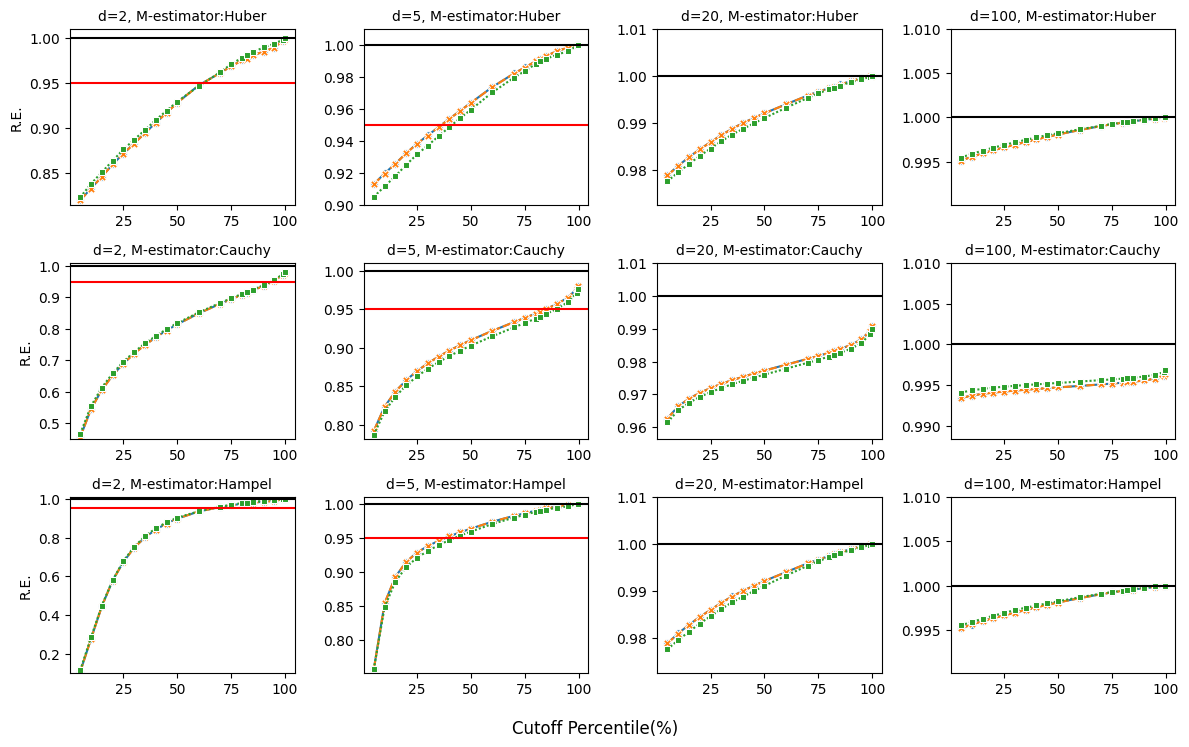

In [309]:
os.makedirs('plots_for_submit',exist_ok=True)
fig,ax = plt.subplots(3,4,figsize=(12,3*2.5))
for i,d in enumerate([2,5,20,100]): #,50,100]):
    for j,(m_est_type,m_name) in enumerate([('mono','Huber'),('softr','Cauchy'),('hardr','Hampel')]):
        tdf = res_df_g_.loc[
                    (res_df_g_['summary_type']=='ARE') &
                    (res_df_g_['mean_type']!='fm') &
                    (res_df_g_['d']==d) &
                    (res_df_g_['cov_type']=='full-rank') &            
                    (res_df_g_['mean_type']==m_est_type) &
                    (res_df_g_['samplingdist']=='gaussian')
                ].copy(deep=True).sort_values(['ptile','manifold']).reset_index(drop=True)
        
        tdf['manifold'] = pd.Categorical(tdf['manifold'],categories=['sphere','euclidean','hyperbolic'],ordered=True)
        tdf['ptile'] = pd.to_numeric(tdf['ptile']) #.str.slice(0,2)
        tdf['R.E.'] = tdf['value']
        
        sns.lineplot(x=tdf.ptile,y=tdf['R.E.'],hue=tdf.manifold,ax=ax[j,i],errorbar=('sd',1),style=tdf.manifold,markers=True,markersize=5.5)  #
        ax[j,i].axhline(y=0.95,c='red')
        ax[j,i].axhline(y=1,c='black')
        ax[j,i].set_ylim(tdf.value.min()-0.005,1.01)
        ax[j,i].set_title(f'd={d}, M-estimator:{m_name}',fontsize='medium')
        ax[j,i].tick_params(axis='x',rotation=0,labelsize='medium')
        ax[j,i].legend(fontsize='x-small',loc='lower right')
        if i!=0:
            ax[j,i].set_ylabel('')
        ax[j,i].set_xlabel('')
        ax[j,i].legend_.remove()
# fig.suptitle('[Relative Efficiency of M-estimators w.r.t Fréchet Mean, Manifolds (Sampled from Gaussian dist.)]')
fig.supxlabel('Cutoff Percentile(%)')
plt.tight_layout()

plt.savefig('plots_for_submit/RE_allinone_manifold_cutoffptiles_gaussian.png')
plt.savefig('plots_for_submit/RE_allinone_manifold_cutoffptiles_gaussian.pdf')
plt.savefig('plots_for_submit/RE_allinone_manifold_cutoffptiles_gaussian.eps')

## RE vs cutoff percentile chart(d = 2,5,20,100) - heavy tail

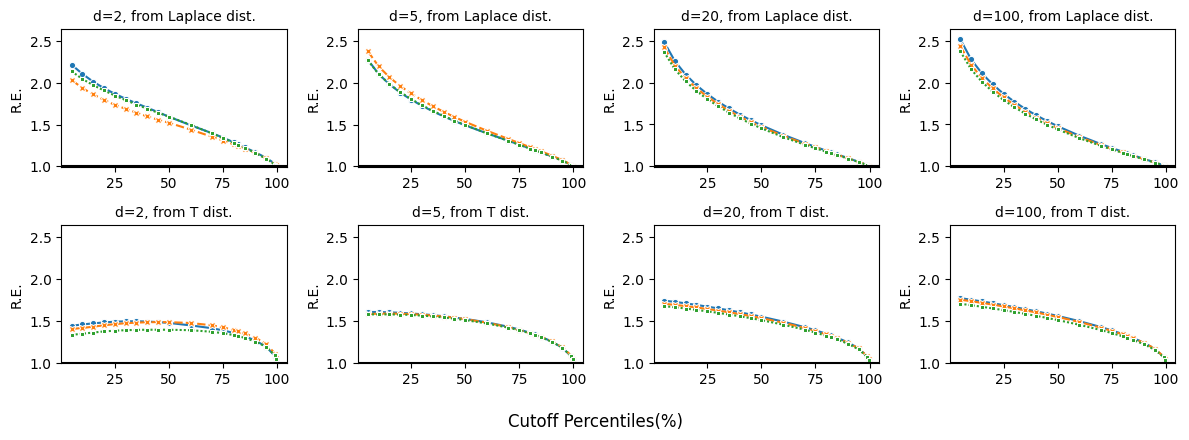

In [310]:
# (a) Huber mean
fig,ax = plt.subplots(2,4,figsize=(12,2*2.2))
for j,sdist in enumerate(['laplace','t']):
    sdist_ = sdist[0].upper()+sdist[1:]
    for i,d in enumerate([2,5,20,100]):
        tdf = res_df_g_.loc[
                    (res_df_g_['summary_type']=='ARE') &
                    (res_df_g_['mean_type']!='fm') &
                    (res_df_g_['d']==d) &
                    (res_df_g_['cov_type']=='full-rank') &            
                    (res_df_g_['mean_type']=='mono') &
                    (res_df_g_['samplingdist']==sdist)
                ].copy(deep=True).sort_values(['ptile','manifold']).reset_index(drop=True)
        tdf['manifold'] = pd.Categorical(tdf['manifold'],categories=['sphere','euclidean','hyperbolic'],ordered=True)
        tdf['ptile'] = pd.to_numeric(tdf['ptile'])
        tdf['R.E.'] = tdf.value
        
        sns.lineplot(x=tdf.ptile,y=tdf['R.E.'],hue=tdf.manifold,errorbar=('sd',1),ax=ax[j,i],style=tdf.manifold,markers=True,markersize=4.5)
        ax[j,i].axhline(y=0.95,c='red')
        ax[j,i].axhline(y=1,c='black')
        ax[j,i].set_ylim(min(tdf.value.min()-0.01,1),2.65)
        ax[j,i].set_title(f'd={d}, from {sdist_} dist.',fontsize='medium')
        ax[j,i].tick_params(axis='x',rotation=0,labelsize='medium')
        # if i!=0:
        #     ax[j,i].set_ylabel('')
        #ax[j,i].legend(fontsize='x-small',loc='upper right')
        ax[j,i].set_xlabel('')
        ax[j,i].legend_.remove()
# fig.suptitle(f'[Relative Efficiency of hampel Mean w.r.t Fréchet Mean(heavy-tailed dist.)]')
fig.supxlabel('Cutoff Percentiles(%)')
plt.tight_layout()

plt.savefig('plots_for_submit/RE_Huber_manifold_cutoffptiles_huber_heavytail.png')
plt.savefig('plots_for_submit/RE_Huber_manifold_cutoffptiles_huber_heavytail.pdf')
plt.savefig('plots_for_submit/RE_Huber_manifold_cutoffptiles_huber_heavytail.eps')


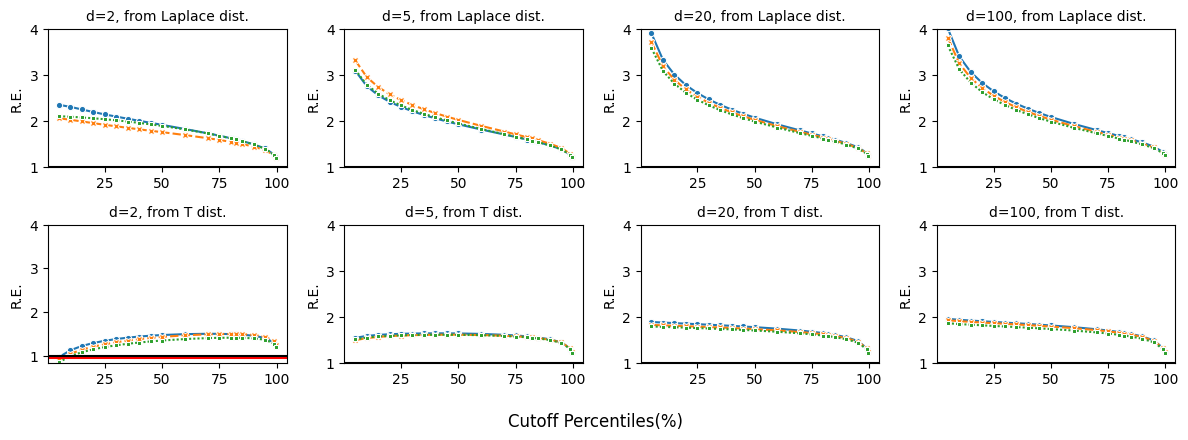

In [311]:
# (b) Cauchy mean
fig,ax = plt.subplots(2,4,figsize=(12,2*2.2))
for j,sdist in enumerate(['laplace','t']):
    sdist_ = sdist[0].upper()+sdist[1:]
    for i,d in enumerate([2,5,20,100]):
        tdf = res_df_g_.loc[
                    (res_df_g_['summary_type']=='ARE') &
                    (res_df_g_['mean_type']!='fm') &
                    (res_df_g_['d']==d) &
                    (res_df_g_['cov_type']=='full-rank') &            
                    (res_df_g_['mean_type']=='softr') &
                    (res_df_g_['samplingdist']==sdist)
                ].copy(deep=True).sort_values(['ptile','manifold']).reset_index(drop=True)
        
        tdf['manifold'] = pd.Categorical(tdf['manifold'],categories=['sphere','euclidean','hyperbolic'],ordered=True)
        tdf['ptile'] = pd.to_numeric(tdf['ptile'])
        tdf['R.E.'] = tdf.value
        
        sns.lineplot(x=tdf.ptile,y=tdf['R.E.'],hue=tdf.manifold,errorbar=('sd',1),ax=ax[j,i],style=tdf.manifold,markers=True,markersize=4.5)
        ax[j,i].axhline(y=0.95,c='red')
        ax[j,i].axhline(y=1,c='black')
        ax[j,i].set_ylim(min(tdf.value.min()-0.01,1),4)
        ax[j,i].set_title(f'd={d}, from {sdist_} dist.',fontsize='medium')
        ax[j,i].tick_params(axis='x',rotation=0,labelsize='medium')
        # if i!=0:
        #     ax[j,i].set_ylabel('')
        #ax[j,i].legend(fontsize='x-small',loc='upper right')
        ax[j,i].set_xlabel('')
        ax[j,i].legend_.remove()
# fig.suptitle(f'[Relative Efficiency of hampel Mean w.r.t Fréchet Mean(heavy-tailed dist.)]')
fig.supxlabel('Cutoff Percentiles(%)')
plt.tight_layout()

plt.savefig('plots_for_submit/RE_Cauchy_manifold_cutoffptiles_Cauchy_heavytail.png')
plt.savefig('plots_for_submit/RE_Cauchy_manifold_cutoffptiles_Cauchy_heavytail.pdf')
plt.savefig('plots_for_submit/RE_Cauchy_manifold_cutoffptiles_Cauchy_heavytail.eps')


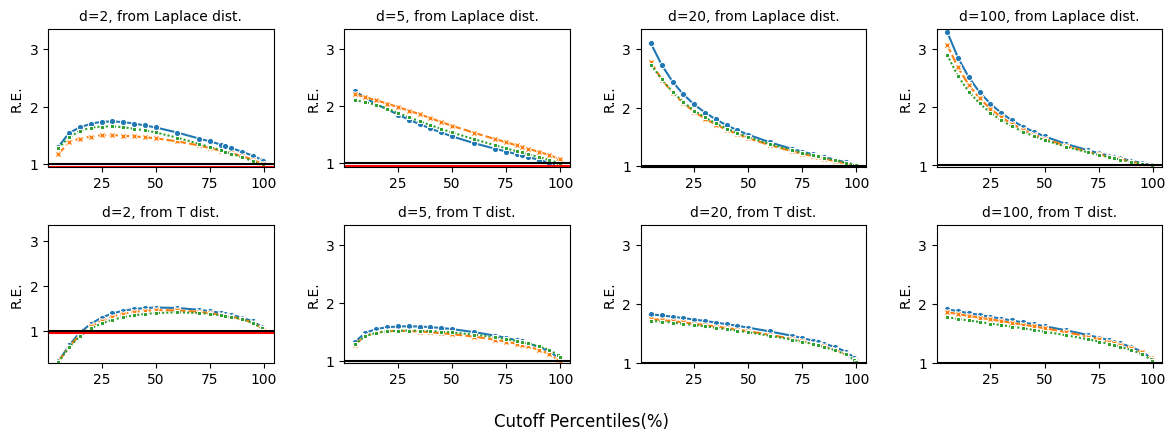

In [312]:
# (c) Hampel mean
fig,ax = plt.subplots(2,4,figsize=(12,2*2.2))
for j,sdist in enumerate(['laplace','t']):
    sdist_ = sdist[0].upper()+sdist[1:]
    for i,d in enumerate([2,5,20,100]):
        tdf = res_df_g_.loc[
                    (res_df_g_['summary_type']=='ARE') &
                    (res_df_g_['mean_type']!='fm') &
                    (res_df_g_['d']==d) &
                    (res_df_g_['cov_type']=='full-rank') &            
                    (res_df_g_['mean_type']=='hardr') &
                    (res_df_g_['samplingdist']==sdist)
                ].copy(deep=True).sort_values(['ptile','manifold']).reset_index(drop=True)
        tdf['manifold'] = pd.Categorical(tdf['manifold'],categories=['sphere','euclidean','hyperbolic'],ordered=True)
        tdf['ptile'] = pd.to_numeric(tdf['ptile'])
        tdf['R.E.'] = tdf.value
        
        sns.lineplot(x=tdf.ptile,y=tdf['R.E.'],hue=tdf.manifold,errorbar=('sd',1),ax=ax[j,i],style=tdf.manifold,markers=True,markersize=4.5)
        ax[j,i].axhline(y=0.95,c='red')
        ax[j,i].axhline(y=1,c='black')
        ax[j,i].set_ylim(min(tdf.value.min()-0.01,1),3.35)
        ax[j,i].set_title(f'd={d}, from {sdist_} dist.',fontsize='medium')
        ax[j,i].tick_params(axis='x',rotation=0,labelsize='medium')
        # if i!=0:
        #     ax[j,i].set_ylabel('')
        #ax[j,i].legend(fontsize='x-small',loc='upper right')
        ax[j,i].set_xlabel('')
        ax[j,i].legend_.remove()
# fig.suptitle(f'[Relative Efficiency of hampel Mean w.r.t Fréchet Mean(heavy-tailed dist.)]')
fig.supxlabel('Cutoff Percentiles(%)')
plt.tight_layout()

plt.savefig('plots_for_submit/RE_hampel_manifold_cutoffptiles_hampel_heavytail.png')
plt.savefig('plots_for_submit/RE_hampel_manifold_cutoffptiles_hampel_heavytail.pdf')
plt.savefig('plots_for_submit/RE_hampel_manifold_cutoffptiles_hampel_heavytail.eps')


# (Not in paper) check whether low-cutoff and low-dimension make M-estimator less efficient.
 > Probably, since mean point cloud of M-estimator seems larger than that of Fr\'echet mean.

(-0.03, 0.03)

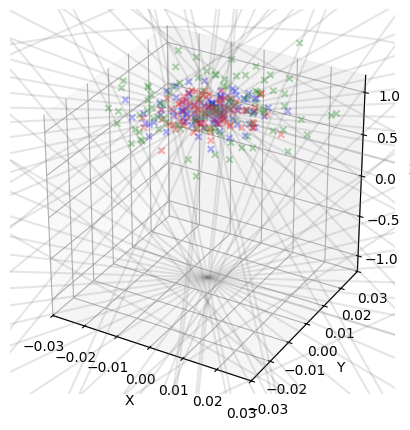

In [313]:
x1 = np.array(res[1000][1][2]['t']['full-rank']['mean']['hardr_5.00'])
x2 = np.array(res[1000][1][2]['t']['full-rank']['mean']['hardr_15.00'])
y = np.array(res[1000][1][2]['t']['full-rank']['mean']['fm'])
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection="3d")
visualization.plot(x1,space='S2',alpha=0.3,marker='x',c='green')
ax.scatter(x2[:,0], x2[:,1], x2[:,2], alpha=0.3, c='blue',marker='x')
ax.scatter(y[:,0], y[:,1], y[:,2], alpha=0.3, c='red',marker='x')
plt.xlim(-0.03,0.03)
plt.ylim(-0.03,0.03)



## (Not in paper) Variance of sample mean with respect to cutoff - heavy tail
 > Seems a cutoff point minimizing the variance exists and minimizing point differs by (effective) dimension.

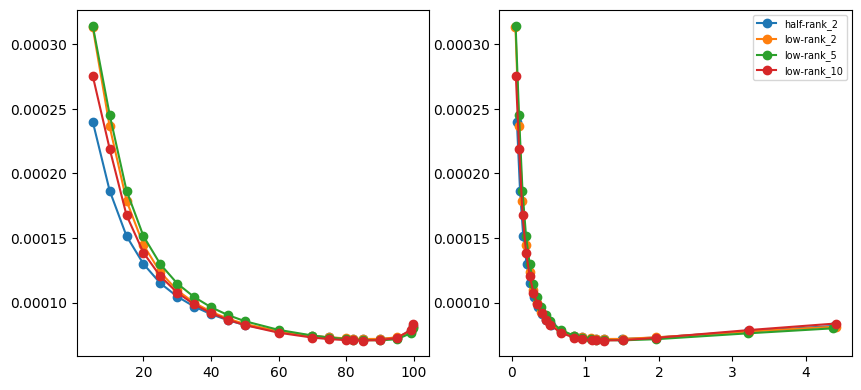

In [314]:
sdt = 't'
mtp = 'softr'
a = res_df_g_.loc[
    (res_df_g_['summary_type']=='ARE') &
    (res_df_g_['mean_type']!='fm') &
    (res_df_g_['manifold']=='sphere') &
    (np.abs(res_df_g_['eff_rank']-1)<=1e-2) &
    (res_df_g_['mean_type']==mtp) &
    (res_df_g_['samplingdist']==sdt)  
].sort_values(['d','ptile','manifold']).reset_index(drop=True).merge(
    res_df_g_.loc[
        (res_df_g_['summary_type']=='sample_mean_var') &
        (res_df_g_['mean_type']!='fm') &
        (res_df_g_['mean_type']==mtp) &
        (res_df_g_['samplingdist']==sdt) 
        ,['d','cov_type','ptile','mean_type','manifold','samplingdist','value']
    ],on=['d','cov_type','ptile','mean_type','manifold','samplingdist'],how='left',suffixes=('','_v')
)
a['ptile'] = pd.to_numeric(a['ptile'])
fig,ax = plt.subplots(1,2,figsize=(10,4.5))
for i,r in a.loc[:,['cov_type','d']].drop_duplicates().iterrows():
    a1 = a.loc[(a['cov_type']==r['cov_type']) & (a['d']==r['d'])].copy(deep=True).sort_values(['d','ptile'])
    cc = '{cov_type}_{d}'.format(**r)
    # a1['ptile'] = pd.to_numeric(a1['ptile'])
    if r['cov_type']=='full-rank':
        ax[0].plot(a1['ptile'],a1['value_v'],'-x',label=cc)
        ax[1].plot(a1['cutoff_ratio'],a1['value_v'],'-x',label=cc)
    else:
        ax[0].plot(a1['ptile'],a1['value_v'],'-o',label=cc)
        ax[1].plot(a1['cutoff_ratio'],a1['value_v'],'-o',label=cc)
ax[1].ticklabel_format(axis="y", style="plain", useOffset=False)
plt.legend(fontsize='x-small')
    #a1 = None

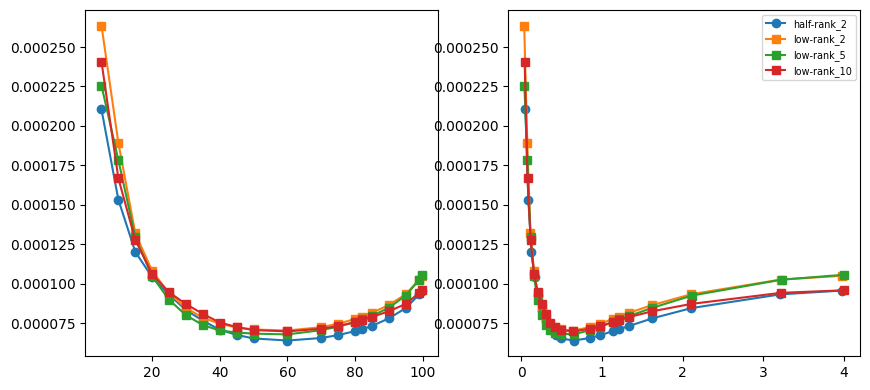

In [315]:
sdt = 'laplace'
mtp = 'hardr'
a = res_df_g_.loc[
    (res_df_g_['summary_type']=='ARE') &
    (res_df_g_['mean_type']!='fm') &
    (res_df_g_['manifold']=='sphere') &
    (np.abs(res_df_g_['eff_rank']-1)<=1e-2) &
    (res_df_g_['mean_type']==mtp) &
    (res_df_g_['samplingdist']==sdt) 
].sort_values(['d','ptile','manifold']).reset_index(drop=True).merge(
    res_df_g_.loc[
        (res_df_g_['summary_type']=='sample_mean_var') &
        (res_df_g_['mean_type']!='fm') &
        (res_df_g_['mean_type']==mtp) &
        (res_df_g_['samplingdist']==sdt)
        ,['d','cov_type','ptile','mean_type','manifold','samplingdist','value']
    ],on=['d','cov_type','ptile','mean_type','manifold','samplingdist'],how='left',suffixes=('','_v')
)
a['ptile'] = pd.to_numeric(a['ptile'])
fig,ax = plt.subplots(1,2,figsize=(10,4.5))
for i,r in a.loc[:,['cov_type','d']].drop_duplicates().iterrows():
    a1 = a.loc[(a['cov_type']==r['cov_type']) & (a['d']==r['d'])].copy(deep=True).sort_values(['d','ptile'])
    cc = '{cov_type}_{d}'.format(**r)
    
    if r['cov_type']=='full-rank':
        ax[0].plot(a1['ptile'],a1['value_v'],'-x',label=cc)
        ax[1].plot(a1['cutoff_ratio'],a1['value_v'],'-x',label=cc)
    elif r['cov_type']=='low-rank':
        ax[0].plot(a1['ptile'],a1['value_v'],'-s',label=cc)
        ax[1].plot(a1['cutoff_ratio'],a1['value_v'],'-s',label=cc)
    else:
        ax[0].plot(a1['ptile'],a1['value_v'],'-o',label=cc)
        ax[1].plot(a1['cutoff_ratio'],a1['value_v'],'-o',label=cc)
ax[1].ticklabel_format(axis="y", style="plain", useOffset=False)
plt.legend(fontsize='x-small')
    #a1 = None

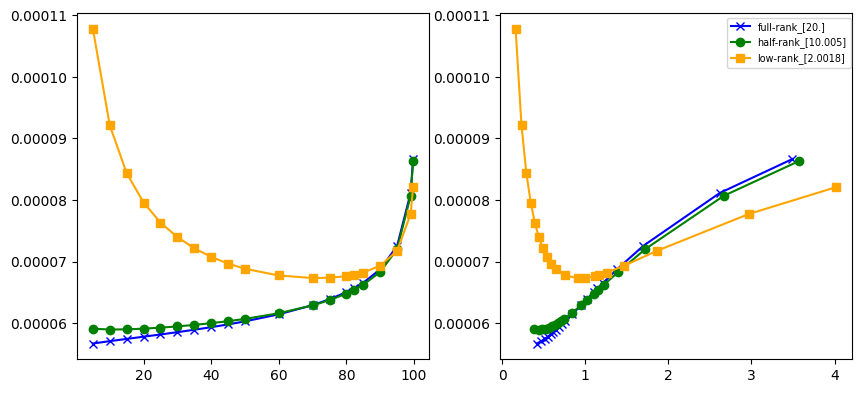

In [316]:
sdt = 't'
mtp = 'softr'
a = res_df_g_.loc[
    (res_df_g_['summary_type']=='ARE') &
    (res_df_g_['mean_type']!='fm') &
    (res_df_g_['manifold']=='sphere') &
    (res_df_g_['d']==20) &
    (res_df_g_['mean_type']==mtp) &
    (res_df_g_['samplingdist']==sdt) 
].sort_values(['d','ptile','manifold']).reset_index(drop=True).merge(
    res_df_g_.loc[
        (res_df_g_['summary_type']=='sample_mean_var') &
        (res_df_g_['mean_type']!='fm') &
        (res_df_g_['mean_type']==mtp) &
        (res_df_g_['samplingdist']==sdt)
        ,['d','cov_type','ptile','mean_type','manifold','samplingdist','value']
    ],on=['d','cov_type','ptile','mean_type','manifold','samplingdist'],how='left',suffixes=('','_v')
)
a['ptile'] = pd.to_numeric(a['ptile'])
fig,ax = plt.subplots(1,2,figsize=(10,4.5))
for i,r in a.loc[:,['cov_type','d']].drop_duplicates().iterrows():
    a1 = a.loc[(a['cov_type']==r['cov_type']) & (a['d']==r['d'])].copy(deep=True).sort_values(['d','ptile'])
    er = a1['eff_rank'].unique()
    cc = '{cov_type}_'.format(**r) + f'{er}'
    
    if r['cov_type']=='full-rank':
        ax[0].plot(a1['ptile'],a1['value_v'],'-x',c='blue',label=cc)
        ax[1].plot(a1['cutoff_ratio'],a1['value_v'],'-x',c='blue',label=cc)
    elif r['cov_type']=='low-rank':
        ax[0].plot(a1['ptile'],a1['value_v'],'-s',c='orange',label=cc)
        ax[1].plot(a1['cutoff_ratio'],a1['value_v'],'-s',c='orange',label=cc)
    else:
        ax[0].plot(a1['ptile'],a1['value_v'],'-o',c='green',label=cc)
        ax[1].plot(a1['cutoff_ratio'],a1['value_v'],'-o',c='green',label=cc)
    a1 = None
ax[1].ticklabel_format(axis="y", style="plain", useOffset=False)
ax[1].legend(fontsize='x-small',bbox_to_anchor=(1.01,1))
    

## (In paper) RE VS Cutoff_ratio($k_{eff}$) BY EFFECTIVE RANK 

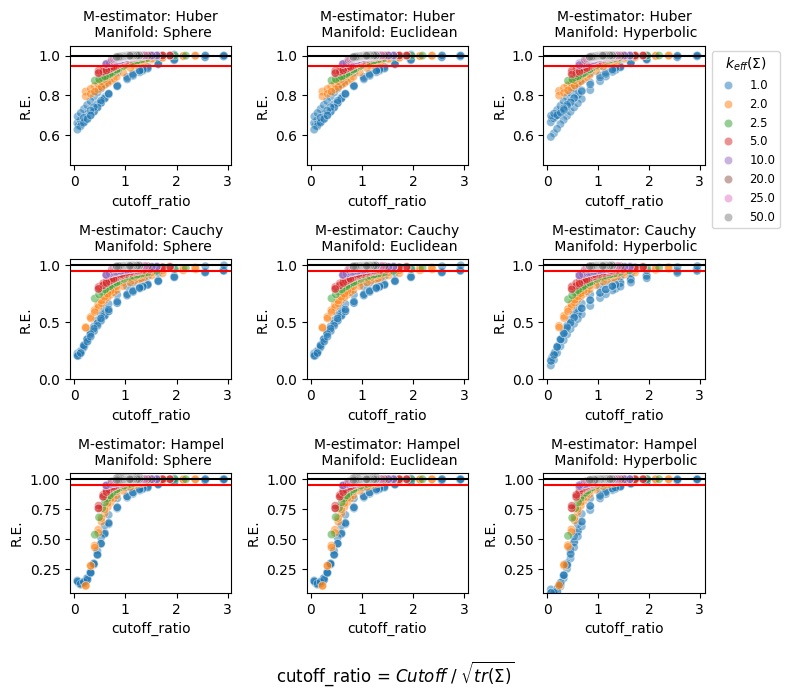

In [317]:
# (a) Gaussian
fig,ax = plt.subplots(3,3,figsize=(8,7))
for i,(mest_type,name) in enumerate([('mono','Huber'),('softr','Cauchy'),('hardr','Hampel')]):
    for j,m in enumerate(['sphere','euclidean','hyperbolic']):
        m_ = m[0].upper()+m[1:]
        tdf = res_df_g_.loc[
                    (res_df_g_['summary_type']=='ARE') &
                    (res_df_g_['mean_type']!='fm') &
                    (res_df_g_['eff_rank']<=55) &
                    (res_df_g_['mean_type']==mest_type) &
                    (res_df_g_['manifold']==m) &
                    (res_df_g_['samplingdist']=='gaussian')
                ].copy(deep=True).sort_values(['eff_rank']).reset_index(drop=True)
        tdf['eff_rank'] = np.round(tdf['eff_rank'],1)
        tdf['R.E.'] = tdf['value']
        tdf = tdf.groupby(['manifold','d','ptile','cov_type'])[['eff_rank','cutoff_ratio','R.E.']].mean().reset_index(
            ).sort_values(['eff_rank']).reset_index(drop=True)
        sns.scatterplot(x=tdf['cutoff_ratio'],y=tdf['R.E.'],hue=tdf['eff_rank'].astype(str),alpha=0.5,ax=ax[i,j])
        #sns.lineplot(x=tdf['cutoff_ratio'],y=tdf['R.E.'],
        #    hue=tdf['eff_rank'].astype(str),errorbar=('sd',1),ax=ax[i,j],style=tdf['eff_rank'].astype(str),markers=True,markersize=4.5,alpha=0.5)
        ax[i,j].axhline(y=0.95,c='red')
        ax[i,j].axhline(y=1,c='black')
        ax[i,j].set_title(f'M-estimator: {name}\n Manifold: {m_}',fontsize='medium') 
        if (i,j)!=(0,2):
            ax[i,j].legend_.remove()
        else:
            ax[i,j].legend(title='$k_{{eff}}(\Sigma)$',bbox_to_anchor=(1.01,1),fontsize='small')
        if mest_type=='mono':
            ax[i,j].set_ylim(0.45,1.05)
        elif mest_type=='softr':
            ax[i,j].set_ylim(0,1.05)
        elif mest_type=='hardr':
            ax[i,j].set_ylim(0.05,1.05)
        ax[i,j].set_xticks([0,1,2,3])
# fig.suptitle('R.E. vs. c/sqrt(tr(Σ)) [Sampling from Gaussian Dist.]')
fig.supxlabel('cutoff_ratio = $Cutoff\;/\;\sqrt{tr(Σ)}$')
plt.tight_layout()

plt.savefig('plots_for_submit/RE_vs_cutoff_by_effrank_gaussian_agg.eps',bbox_inches='tight')
plt.savefig('plots_for_submit/RE_vs_cutoff_by_effrank_gaussian_agg.pdf',bbox_inches='tight')
plt.savefig('plots_for_submit/RE_vs_cutoff_by_effrank_gaussian_agg.png',bbox_inches='tight')

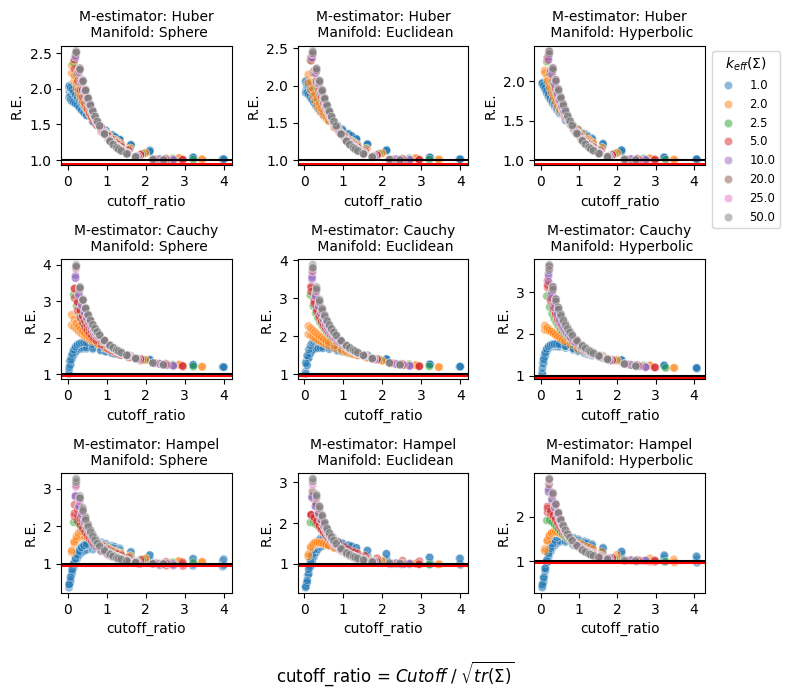

In [318]:
# (b) Laplace
fig,ax = plt.subplots(3,3,figsize=(8,7))
for i,(mest_type,name) in enumerate([('mono','Huber'),('softr','Cauchy'),('hardr','Hampel')]):
    for j,m in enumerate(['sphere','euclidean','hyperbolic']):
        m_ = m[0].upper()+m[1:]
        tdf = res_df_g_.loc[
                    (res_df_g_['summary_type']=='ARE') &
                    (res_df_g_['mean_type']!='fm') &
                    (res_df_g_['eff_rank']<=55) &
                    (res_df_g_['mean_type']==mest_type) &
                    (res_df_g_['manifold']==m) &
                    (res_df_g_['samplingdist']=='laplace') 
                ].copy(deep=True).sort_values(['eff_rank']).reset_index(drop=True)
        tdf['eff_rank'] = np.round(tdf['eff_rank'],1)
        tdf['R.E.'] = tdf['value']
        tdf = tdf.groupby(['manifold','d','ptile','cov_type'])[['eff_rank','cutoff_ratio','R.E.']].mean().reset_index(
            ).sort_values(['eff_rank','d']).reset_index(drop=True)
        sns.scatterplot(x=tdf['cutoff_ratio'],y=tdf['R.E.'],hue=tdf['eff_rank'].astype(str),alpha=0.5,ax=ax[i,j])
        #sns.lineplot(x=tdf['cutoff_ratio'],y=tdf['R.E.'],
        #    hue=tdf['eff_rank'].astype(str),errorbar=('sd',1),ax=ax[i,j],style=tdf['d'].astype(str),markers=True,markersize=4.5,alpha=0.5)
        ax[i,j].axhline(y=0.95,c='red')
        ax[i,j].axhline(y=1,c='black')
        ax[i,j].set_title(f'M-estimator: {name}\n Manifold: {m_}',fontsize='medium') 
        if (i,j)!=(0,2):
            ax[i,j].legend_.remove()
        else:
            ax[i,j].legend(title='$k_{{eff}}(\Sigma)$',bbox_to_anchor=(1.01,1),fontsize='small')

        ax[i,j].set_xticks([0,1,2,3,4])
# fig.suptitle('R.E. vs. c/sqrt(tr(Σ)) [Sampling from Laplace Dist.]')
fig.supxlabel('cutoff_ratio = $Cutoff\;/\;\sqrt{tr(Σ)}$')
plt.tight_layout()

plt.savefig('plots_for_submit/RE_vs_cutoff_by_effrank_laplace_agg.eps',bbox_inches='tight')
plt.savefig('plots_for_submit/RE_vs_cutoff_by_effrank_laplace_agg.pdf',bbox_inches='tight')
plt.savefig('plots_for_submit/RE_vs_cutoff_by_effrank_laplace_agg.png',bbox_inches='tight')

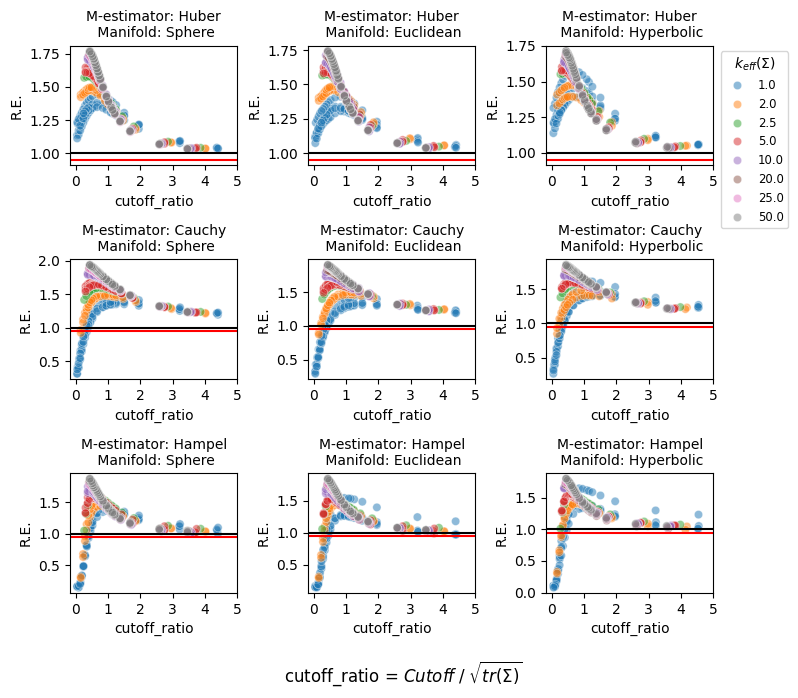

In [319]:
# (c) t
fig,ax = plt.subplots(3,3,figsize=(8,7))
for i,(mest_type,name) in enumerate([('mono','Huber'),('softr','Cauchy'),('hardr','Hampel')]):
    for j,m in enumerate(['sphere','euclidean','hyperbolic']):
        m_ = m[0].upper()+m[1:]
        tdf = res_df_g_.loc[
                    (res_df_g_['summary_type']=='ARE') &
                    (res_df_g_['mean_type']!='fm') &
                    (res_df_g_['eff_rank']<=55) &
                    (res_df_g_['mean_type']==mest_type) &
                    (res_df_g_['manifold']==m) &
                    (res_df_g_['samplingdist']=='t')
                ].copy(deep=True).sort_values(['eff_rank']).reset_index(drop=True)
        tdf['eff_rank'] = np.round(tdf['eff_rank'],1)
        tdf['R.E.'] = tdf['value']
        tdf = tdf.groupby(['manifold','d','ptile','cov_type'])[['eff_rank','cutoff_ratio','R.E.']].mean().reset_index(
            ).sort_values(['eff_rank']).reset_index(drop=True)
        sns.scatterplot(x=tdf['cutoff_ratio'],y=tdf['R.E.'],hue=tdf['eff_rank'].astype(str),alpha=0.5,ax=ax[i,j])
        #sns.lineplot(x=tdf['cutoff_ratio'],y=tdf['R.E.'],
        #    hue=tdf['eff_rank'].astype(str),errorbar=('sd',1),ax=ax[i,j],style=tdf['eff_rank'].astype(str),markers=True,markersize=4.5,alpha=0.5)
        ax[i,j].axhline(y=0.95,c='red')
        ax[i,j].axhline(y=1,c='black')
        ax[i,j].set_title(f'M-estimator: {name}\n Manifold: {m_}',fontsize='medium') 
        if (i,j)!=(0,2):
            ax[i,j].legend_.remove()
        else:
            ax[i,j].legend(title='$k_{{eff}}(\Sigma)$',bbox_to_anchor=(1.01,1),fontsize='small')
        
        ax[i,j].set_xticks([0,1,2,3,4,5])
# fig.suptitle('R.E. vs. c/sqrt(tr(Σ)) [Sampling from t Dist.]')
fig.supxlabel('cutoff_ratio = $Cutoff\;/\;\sqrt{tr(Σ)}$')
plt.tight_layout()

plt.savefig('plots_for_submit/RE_vs_cutoff_by_effrank_t_agg.eps',bbox_inches='tight')
plt.savefig('plots_for_submit/RE_vs_cutoff_by_effrank_t_agg.pdf',bbox_inches='tight')
plt.savefig('plots_for_submit/RE_vs_cutoff_by_effrank_t_agg.png',bbox_inches='tight')

## (In paper) Comparing chart of Gaussian/Laplace distribution on sphere for explaining RE>1 when sampled from heavy-tailed distribution.

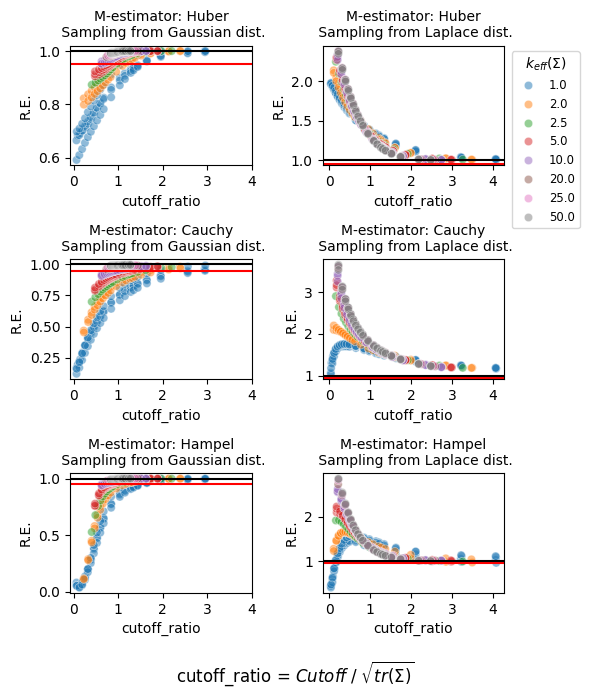

In [320]:
fig,ax = plt.subplots(3,2,figsize=(6,7))
mfld = 'hyperbolic'
for i,(mest_type,name) in enumerate([('mono','Huber'),('softr','Cauchy'),('hardr','Hampel')]):
    for j,m in enumerate(['gaussian','laplace']): #,'t']):
        m_ = m[0].upper()+m[1:]
        tdf = res_df_g_.loc[
                    (res_df_g_['summary_type']=='ARE') &
                    (res_df_g_['mean_type']!='fm') &
                    (res_df_g_['eff_rank']<=55) &
                    (res_df_g_['mean_type']==mest_type) &
                    (res_df_g_['manifold']==mfld) &
                    (res_df_g_['samplingdist']==m) 
                ].copy(deep=True).sort_values(['eff_rank']).reset_index(drop=True)
        tdf['eff_rank'] = np.round(tdf['eff_rank'],1)
        tdf['R.E.'] = tdf['value']
        tdf = tdf.groupby(['manifold','d','ptile','cov_type'])[['eff_rank','cutoff_ratio','R.E.']].mean().reset_index(
            ).sort_values(['eff_rank','d']).reset_index(drop=True)
        sns.scatterplot(x=tdf['cutoff_ratio'],y=tdf['R.E.'],hue=tdf['eff_rank'].astype(str),alpha=0.5,ax=ax[i,j])
        #sns.lineplot(x=tdf['cutoff_ratio'],y=tdf['R.E.'],
        #    hue=tdf['eff_rank'].astype(str),errorbar=('sd',1),ax=ax[i,j],style=tdf['d'].astype(str),markers=True,markersize=4.5,alpha=0.5)
        ax[i,j].axhline(y=0.95,c='red')
        ax[i,j].axhline(y=1,c='black')
        ax[i,j].set_title(f'M-estimator: {name}\n Sampling from {m_} dist.',fontsize='medium') 
        if (i,j)!=(0,1):
            ax[i,j].legend_.remove()
        else:
            ax[i,j].legend(title='$k_{{eff}}(\Sigma)$',bbox_to_anchor=(1.01,1),fontsize='small')

        ax[i,j].set_xticks([0,1,2,3,4])
# fig.suptitle('R.E. vs. c/sqrt(tr(Σ)) [Sampling from Gaussian Dist.]')
fig.supxlabel('cutoff_ratio = $Cutoff\;/\;\sqrt{tr(Σ)}$')
plt.tight_layout()
#fig.subplots_adjust(wspace=0.35, hspace=0.25,bottom=0.08)


plt.savefig(f'plots_for_submit/RE_vs_cutoff_by_effrank_gaussian_laplace_agg_{mfld}.eps',bbox_inches='tight')
plt.savefig(f'plots_for_submit/RE_vs_cutoff_by_effrank_gaussian_laplace_agg_{mfld}.pdf',bbox_inches='tight')
plt.savefig(f'plots_for_submit/RE_vs_cutoff_by_effrank_gaussian_laplace_agg_{mfld}.png',bbox_inches='tight')

# (Not in paper) Check whether d(not effective dimension) affects RE in low dimension
> Doesn't seem to have monotone relation (only effective rank matters) because when effective rank is 1, d=10 increases RE but when effective rank is 2, d=20 decreases RE.

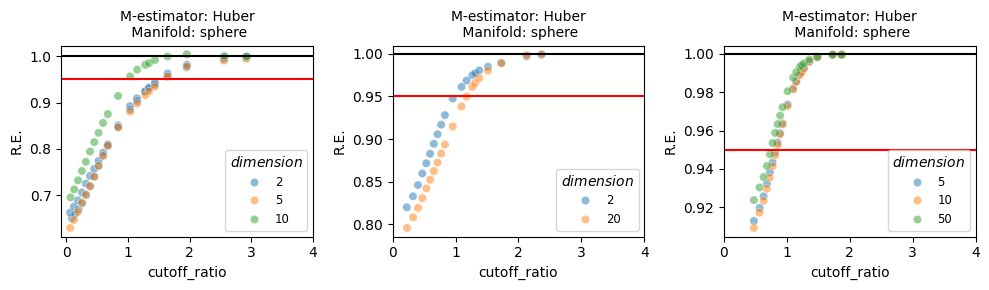

In [321]:
fig,ax = plt.subplots(1,3,figsize=(10,3))

for i,trank in enumerate([1,2,5]):
    tdf = res_df_g_.loc[
                        (res_df_g_['summary_type']=='ARE') &
                        (res_df_g_['mean_type']!='fm') &
                        (np.abs(res_df_g_['eff_rank']-trank)<=1e-2) &
                        (res_df_g_['mean_type']=='mono') &
                        (res_df_g_['manifold']=='sphere') &
                        (res_df_g_['samplingdist']=='gaussian')  #gaussian
                    ].copy(deep=True).sort_values(['eff_rank']).reset_index(drop=True)
    tdf['eff_rank'] = np.round(tdf['eff_rank'],1)
    tdf['R.E.'] = tdf['value']
    tdf = tdf.groupby(['manifold','d','ptile','cov_type'])[['eff_rank','cutoff_ratio','R.E.']].mean().reset_index(
        ).sort_values(['eff_rank','d']).reset_index(drop=True)
    sns.scatterplot(x=tdf['cutoff_ratio'],y=tdf['R.E.'],hue=tdf['d'].astype(str),alpha=0.5,ax=ax[i])
    #sns.lineplot(x=tdf['cutoff_ratio'],y=tdf['R.E.'],
    #    hue=tdf['eff_rank'].astype(str),errorbar=('sd',1),ax=ax[i,j],style=tdf['d'].astype(str),markers=True,markersize=4.5,alpha=0.5)
    ax[i].axhline(y=0.95,c='red')
    ax[i].axhline(y=1,c='black')
    m_ = 'sphere'
    ax[i].set_title(f'M-estimator: Huber\n Manifold: {m_}',fontsize='medium') 
    #if (i)!=(2):
    #    ax[i].legend_.remove()
    #else:
    ax[i].legend(title='$dimension$',fontsize='small')

    ax[i].set_xticks([0,1,2,3,4])
#fig.subplots_adjust(wspace=0.35, hspace=0.25,bottom=0.08)
plt.tight_layout()

## (Not in paper) d=10 and low-rank($k_{eff} = 1$), unnaturally high RE.
#### This seems due to sampling bias, I found lower RE by different seed empirically.


mono_5.00     0.689690
mono_10.00    0.704291
mono_15.00    0.721231
mono_20.00    0.738976
mono_25.00    0.757419
mono_30.00    0.776367
mono_35.00    0.794380
mono_40.00    0.811966
mono_45.00    0.830531
mono_50.00    0.848723
mono_60.00    0.887326
mono_70.00    0.925935
mono_75.00    0.941476
mono_80.00    0.953929
mono_82.13    0.958782
mono_85.00    0.966180
mono_90.00    0.977848
mono_95.00    0.988941
mono_99.00    0.997279
mono_99.73    0.998639
dtype: float64


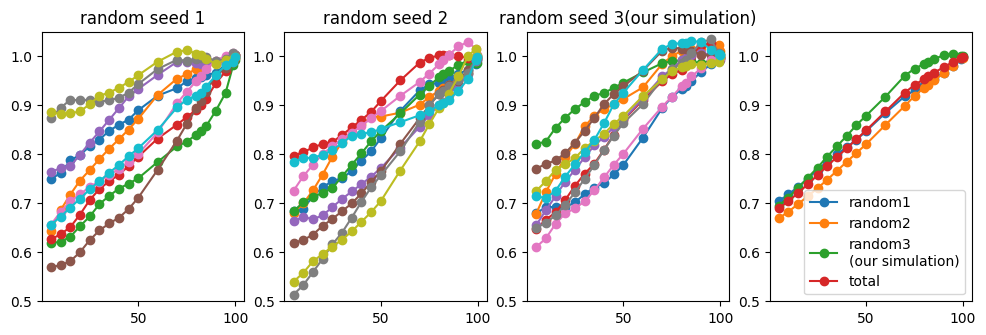

In [322]:
folder = 'old_rawdata/sphere_2_seedtest'
res_seedtest = {}
for n_samples in [1000]: #,300]: #= 25
    res_seedtest[n_samples] = {}
    for i in range(10):
        ix = f'_{i}'  #'' if i==0 else 
        with open(f'{folder}/varofsamplemean_simul_n{n_samples}_dim10_cov3type_mest_251105{ix}.pkl','rb') as f_:
            res_seedtest[n_samples][i] = pickle.load(f_)
            
folder = 'old_rawdata/sphere_3_seedtest'
# res = {}
for n_samples in [1000]: #,300]: #= 25
    #res[n_samples] = {}
    for i in range(10):
        ix = f'_{i}'  #'' if i==0 else 
        with open(f'{folder}/varofsamplemean_simul_n{n_samples}_dim10_cov3type_mest_251105{ix}.pkl','rb') as f_:
            res_seedtest[n_samples][i+10] = pickle.load(f_)

folder = 'old_rawdata/sphere'
# res = {}
for n_samples in [1000]: #,300]: #= 25
    #res[n_samples] = {}
    for i in range(10):
        ix = f'_{i}'  #'' if i==0 else 
        with open(f'{folder}/varofsamplemean_simul_n{n_samples}_dim2510_cov4type_mest_251105{ix}.pkl','rb') as f_:
            res_seedtest[n_samples][i+20] = pickle.load(f_)

RE = {}
for i in range(30):
    fm_var = res_seedtest[1000][i][10]['gaussian']['low-rank']['sample_mean_var']['fm']
    for m,v in res_seedtest[1000][i][10]['gaussian']['low-rank']['sample_mean_var'].items():
        if m[0]=='m':
            if m not in RE:
                RE[m] = []
            RE[m].append(fm_var/v[0])

RE = pd.DataFrame(RE).astype(float)
x = pd.to_numeric(RE.columns.str.slice(5,))

fig,ax = plt.subplots(1,4,figsize=(12,3.5))
for i in range(10):
    ax[0].plot(x,RE.loc[i],'o-')
ax[0].set_title('random seed 1')
for i in range(10,20):
    ax[1].plot(x,RE.loc[i],'o-')
ax[1].set_title('random seed 2')
for i in range(20,30):
    ax[2].plot(x,RE.loc[i],'o-')
ax[2].set_title('random seed 3(our simulation)')
ax[3].plot(x,RE.iloc[:10].mean(axis=0).to_numpy(),'o-',label='random1')
ax[3].plot(x,RE.iloc[10:20].mean(axis=0).to_numpy(),'o-',label='random2')
ax[3].plot(x,RE.iloc[20:30].mean(axis=0).to_numpy(),'o-',label='random3\n(our simulation)')
ax[3].plot(x,RE.mean(axis=0).to_numpy(),'o-',label='total')

ax[0].set_ylim(0.5,1.05)
ax[1].set_ylim(0.5,1.05)
ax[2].set_ylim(0.5,1.05)
ax[3].set_ylim(0.5,1.05)
ax[3].legend()
print(RE.mean(axis=0))

In [323]:
RE.iloc[:10].astype(float).mean(axis=0)

mono_5.00     0.704592
mono_10.00    0.718252
mono_15.00    0.733623
mono_20.00    0.750030
mono_25.00    0.768805
mono_30.00    0.785455
mono_35.00    0.800443
mono_40.00    0.814126
mono_45.00    0.829673
mono_50.00    0.847010
mono_60.00    0.884391
mono_70.00    0.918509
mono_75.00    0.930633
mono_80.00    0.941162
mono_82.13    0.945950
mono_85.00    0.953284
mono_90.00    0.966403
mono_95.00    0.980122
mono_99.00    0.995013
mono_99.73    0.999410
dtype: float64

# Variance plotting

## (In paper) variance of sample mean by loss, distribution, dim = 2,10,100 with a variety of cutoff, Full rank

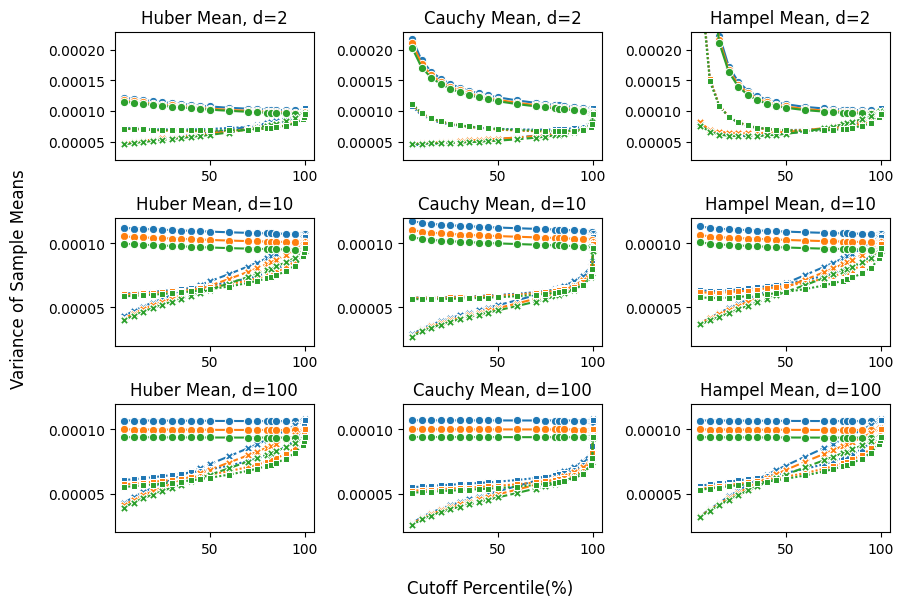

In [324]:
m_est_name = {'mono':'Huber','softr':'Cauchy','hardr':'Hampel'}
fig,ax = plt.subplots(3,3,figsize=(10,6.5))
for j,m_est_type in enumerate(['mono','softr','hardr']):
    for i,d in enumerate([2,10,100]):
        tdf = res_df_g_.loc[
            (res_df_g_['summary_type']=='sample_mean_var') &
            (res_df_g_['d']==d) &
            (res_df_g_['cov_type']=='full-rank') &
            ((res_df_g_['mean_type']==m_est_type) | (res_df_g_['mean_type'].isin(['fm'])))   #,'gm'
        ].reset_index(drop=True).copy(deep=True)

        tdf['Cutoff Percentile'] = pd.to_numeric(tdf['ptile'])
        tdf['Cutoff Percentile'] = np.where(tdf['mean_type']=='fm',100.0,tdf['Cutoff Percentile'])
        tdf = tdf.sort_values(['Cutoff Percentile','samplingdist']).reset_index(drop=True)

        m_name = m_est_name[m_est_type]
        sns.lineplot(data=tdf,x='Cutoff Percentile',y='value',hue='manifold',style='samplingdist',errorbar=None,markers=True,ax=ax[i,j]) #,markersize=3.75)  #[tdf['ptile']!='00.00']  errorbar=None,
        ax[i,j].set_ylabel('')
        ax[i,j].set_xlabel('')
        ax[i,j].set_title(f'{m_name} Mean, d={d}')
        # ax[i,j].set_xlabel('Variance of Sample Means')
        # if (i==0) and (j==2):
        #     ax[i,j].legend(bbox_to_anchor=(1.01,1))
        # else:
        #     ax[i,j].legend_.remove()
        ax[i,j].legend_.remove()
        if i==0:
            ax[i,j].set_ylim(0.00002,0.00023)
            ax[i,j].set_yticks([0.00005,0.00010,0.00015,0.00020])
        else:
            ax[i,j].set_ylim(0.00002,0.00012)
            ax[i,j].set_yticks([0.00005,0.00010])
fig.supylabel(f'Variance of Sample Means')
fig.supxlabel(f'Cutoff Percentile(%)')
fig.subplots_adjust(wspace=0.45, hspace=0.45)
plt.savefig('plots_for_submit/variance_by_loss_distribution_manifold_dim.eps')
plt.savefig('plots_for_submit/variance_by_loss_distribution_manifold_dim.png')
plt.savefig('plots_for_submit/variance_by_loss_distribution_manifold_dim.pdf')
# plt.tight_layout()

In [325]:
tdf[tdf.samplingdist=='gaussian'].groupby(['samplingdist','ptile','manifold']).value.mean()  #.reset_index().iloc[:50]

samplingdist  ptile  manifold  
gaussian      0.00   euclidean     0.000099
                     hyperbolic    0.000093
                     sphere        0.000106
              5.00   euclidean     0.000100
                     hyperbolic    0.000094
                                     ...   
              99.00  hyperbolic    0.000093
                     sphere        0.000106
              99.73  euclidean     0.000099
                     hyperbolic    0.000093
                     sphere        0.000106
Name: value, Length: 63, dtype: float64

In [326]:
print('sphere variance(+a): ',106/99, 'hyperbolic variance(-a): ',93/99)

sphere variance(+a):  1.0707070707070707 hyperbolic variance(-a):  0.9393939393939394


## (Not in paper) variance of sample mean by loss, distribution, effective ranks in dim = 20 with a variety of cutoff.

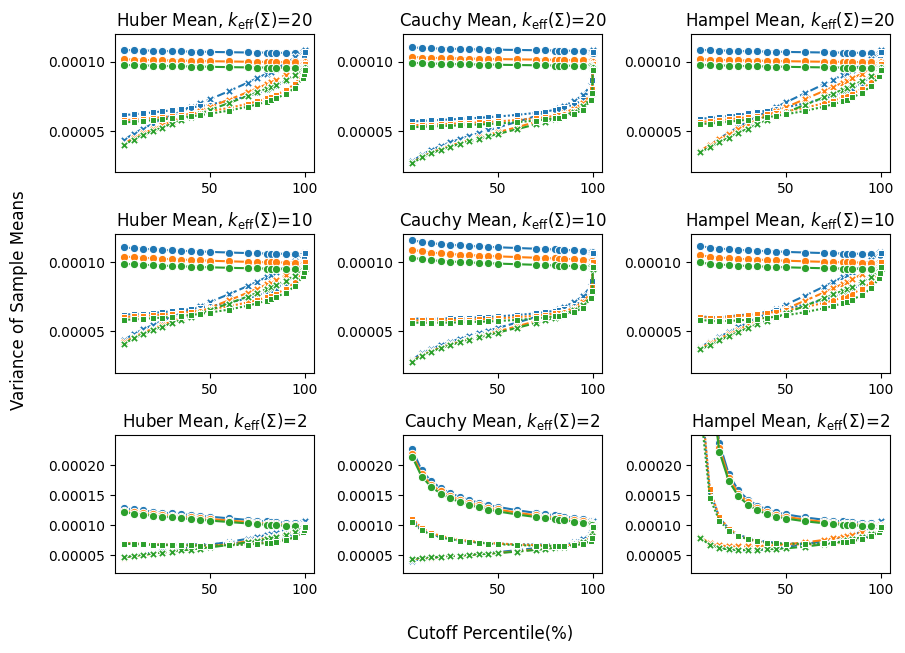

In [327]:
d = 20
m_est_name = {'mono':'Huber','softr':'Cauchy','hardr':'Hampel'}
fig,ax = plt.subplots(3,3,figsize=(10,7))
for j,m_est_type in enumerate(['mono','softr','hardr']):
    for i,ct in enumerate(['full-rank','half-rank','low-rank']):
        if ct == 'full-rank':
            d_ = d
        elif ct == 'half-rank':
            d_ = d*0.5
        else:
            d_ = d*0.1
    
        tdf = res_df_g_.loc[
            (res_df_g_['summary_type']=='sample_mean_var') &
            (res_df_g_['d']==d) &
            (res_df_g_['cov_type']==ct) &
            ((res_df_g_['mean_type']==m_est_type) | (res_df_g_['mean_type'].isin(['fm'])))   #,'gm'
        ].reset_index(drop=True).copy(deep=True)

        tdf['Cutoff Percentile'] = pd.to_numeric(tdf['ptile'])
        tdf['Cutoff Percentile'] = np.where(tdf['mean_type']=='fm',100.0,tdf['Cutoff Percentile'])
        tdf = tdf.sort_values(['Cutoff Percentile','samplingdist']).reset_index(drop=True)
        m_name = m_est_name[m_est_type]
        sns.lineplot(data=tdf,x='Cutoff Percentile',y='value',hue='manifold',style='samplingdist',markers=True,ax=ax[i,j],errorbar=None)  #[tdf['ptile']!='00.00']
        ax[i,j].set_ylabel('')
        ax[i,j].set_xlabel('')
        ax[i,j].set_title(f'{m_name} Mean, '+r"$k_{\mathrm{eff}}(\Sigma)$="+f'{d_:.0f}')
        # ax[i,j].set_xlabel('Variance of Sample Means')
        # if (i==0) and (j==2):
        #     ax[i,j].legend(bbox_to_anchor=(1.01,1))
        # else:
        ax[i,j].legend_.remove()
        if i==2:
            ax[i,j].set_ylim(0.00002,0.00025)
            ax[i,j].set_yticks([0.00005,0.00010,0.00015,0.00020])
        else:
            ax[i,j].set_ylim(0.00002,0.00012)
            ax[i,j].set_yticks([0.00005,0.00010])
        # ax[i,j].set_ylim(0.00003,0.00018)
        # ax[i,j].set_yticks([0.00005,0.00010,0.00015])
fig.supylabel(f'Variance of Sample Means')
fig.supxlabel(f'Cutoff Percentile(%)')
fig.subplots_adjust(wspace=0.45, hspace=0.45)
plt.savefig('plots_for_submit/variance_by_loss_distribution_manifold_rank.eps')
plt.savefig('plots_for_submit/variance_by_loss_distribution_manifold_rank.png')
plt.savefig('plots_for_submit/variance_by_loss_distribution_manifold_rank.pdf')
# plt.tight_layout()

### (Not in paper) less point version of variance of means by dimension/manifold/M-estimators

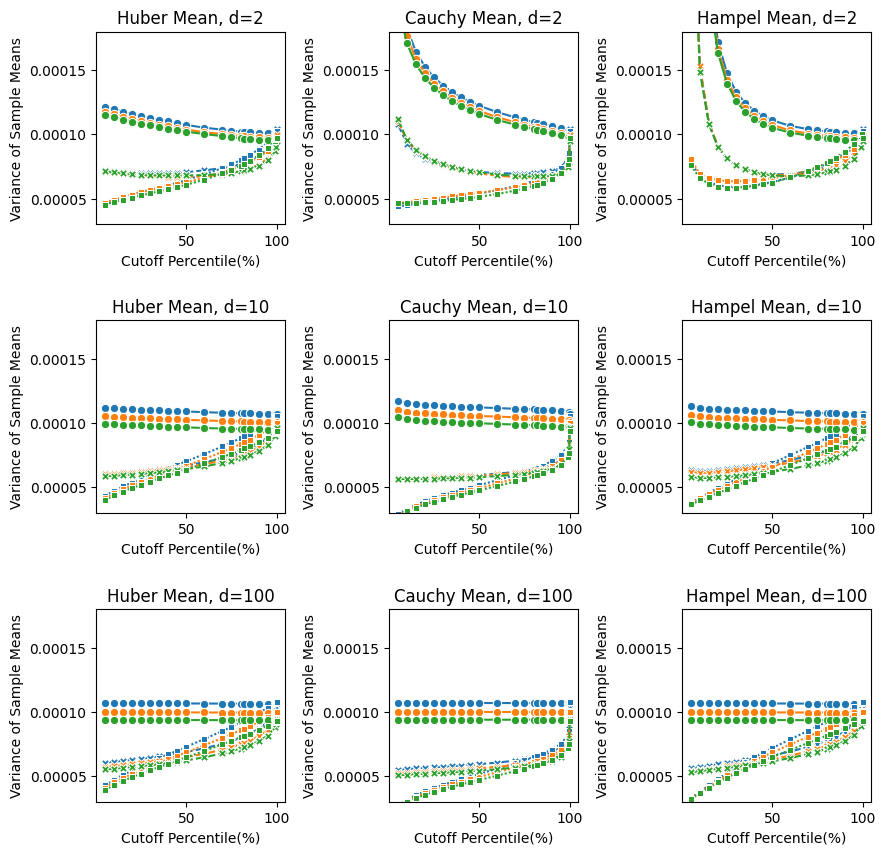

In [328]:
m_est_name = {'mono':'Huber','softr':'Cauchy','hardr':'Hampel'}
fig,ax = plt.subplots(3,3,figsize=(10,10))
for j,m_est_type in enumerate(['mono','softr','hardr']):
    for i,d in enumerate([2,10,100]):
        tdf = res_df_g_.loc[
            (res_df_g_['summary_type']=='sample_mean_var') &
            (res_df_g_['d']==d) &
            (res_df_g_['cov_type']=='full-rank') &
            ((res_df_g_['mean_type']==m_est_type) | (res_df_g_['mean_type'].isin(['fm'])))   #,'gm'
        ].reset_index(drop=True).copy(deep=True)
        
        tdf['Cutoff Percentile'] = pd.to_numeric(tdf['ptile'])
        tdf['Cutoff Percentile'] = np.where(tdf['mean_type']=='fm',100.0,tdf['Cutoff Percentile'])
        m_name = m_est_name[m_est_type]
        sns.lineplot(data=tdf,x='Cutoff Percentile',y='value',hue='manifold',style='samplingdist',markers=True,ax=ax[i,j],errorbar=None)  
        ax[i,j].set_ylabel(f'Variance of Sample Means')
        ax[i,j].set_xlabel(f'Cutoff Percentile(%)')
        ax[i,j].set_title(f'{m_name} Mean, d={d}')
        # ax[i,j].set_xlabel('Variance of Sample Means')
        # if (i==0) and (j==2):
        #     ax[i,j].legend(bbox_to_anchor=(1.01,1))
        # else:
        ax[i,j].legend_.remove()
        ax[i,j].set_ylim(0.00003,0.00018)
        ax[i,j].set_yticks([0.00005,0.00010,0.00015])
fig.subplots_adjust(wspace=0.55, hspace=0.5)
# plt.tight_layout()

## (Not in paper) Sq.bias, Variance, Var/Sq.bias plotting

In [ ]:
m_est_type = 'mono'
dfs = {}
dfs[m_est_type] = {}
fig,ax = plt.subplots(4,3,figsize=(12,15))
for j,d in enumerate([2,5,10,100]):
    dfs[m_est_type][d] = {}
    for i,v in enumerate(['sq_bias','sample_mean_var']):
        tdf = res_df_g_.loc[
            (res_df_g_['summary_type']=='mean') &
            (res_df_g_['d']==d) &
            (res_df_g_['v']==v) &
            ((res_df_g_['mean_type']==m_est_type) | (res_df_g_['mean_type'].isin(['fm','gm']))) &
            (res_df_g_['samplingdist']=='gaussian')
        ].reset_index(drop=True).copy(deep=True)
        
        if m_est_type=='hardr':
            tdf = tdf[tdf.ptile.isin(['70.00','75.00','80.00','85.00','90.00','95.00','99.00','99.73'])].reset_index(drop=True)
        tdf['manifold'] = np.where(tdf['manifold']=='euclidean','R',np.where(tdf['manifold']=='hyperbolic','H','S'))
        tdf['xlabel'] = 'Eff.R('+pd.Series(np.round(tdf['eff_rank'],2).astype(str))+')+'+tdf['manifold']
        tdf['ptile'] = np.where(tdf['mean_type']=='fm','99.99\n(Frechet_Mean)',
                                np.where(tdf['mean_type']=='gm','00.00\n(Geo_Med)',
                                         tdf['ptile']))
                                
        tdf = tdf.sort_values(['cov_type','manifold','ptile']).reset_index(drop=True)
        dfs[m_est_type][d][i] = tdf.copy()
        
        tdf[v] = tdf['value']
        sns.barplot(data=tdf,x='xlabel',y=v,hue='ptile',ax=ax[j,i],errorbar='ci',errwidth=0.35)
        # ax.axhline(y=0.95,c='r')
        # ax.axhline(y=1,c='k')
        # if m_est_type!='hardr':
        #     ax.set_ylim(0.65,1.05)
        # if i==1:
        #     ax[j,i].legend(loc='upper left',fontsize='xx-small',bbox_to_anchor=(1.01,1))
        # else:
        ax[j,i].legend_.remove()
        ax[j,i].set_title(f'[{v}] d={d}, M_estimator:{m_est_type}',fontsize='small')
        ax[j,i].tick_params(axis='x',rotation=90)
        ax[j,i].ticklabel_format(style='plain', axis='y')
        ax[j,i].set_xlabel('')
    # ax[1].set_ylim(0.00005,0.00011)
    dfs_ = dfs[m_est_type][d][0].merge(dfs[m_est_type][d][1],on=['n','d','cov_type','eff_rank','trace_cov','samplingdist','xlabel',
                                   'variable','mean_type','ptile','summary_type','manifold'],how='left')
    dfs_['ratio'] = dfs_['value_y']/dfs_['value_x']
    sns.barplot(data=dfs_,x='xlabel',y='ratio',hue='ptile',ax=ax[j,2],errorbar='ci',errwidth=0.35)
    ax[j,2].set_title(f'[Var/Sq.Bias] d={d}, M_estimator:{m_est_type}',fontsize='small')
    ax[j,2].legend(loc='upper left',fontsize='xx-small',bbox_to_anchor=(1.01,1))
    ax[j,2].tick_params(axis='x',rotation=90)
    ax[j,2].ticklabel_format(style='plain', axis='y')
    ax[j,2].set_xlabel('')
    ax[j,2].set_yscale('log')
plt.tight_layout()
# plt.savefig('plots/sq_bias_variance_wrt_d_cutoffptiles_huber.png')